In [1]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "axes.labelsize": 24,
        "legend.fontsize": 24,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="darkorange")

import pandas as pd
from fiesta.plot import latex_labels
from fiesta.plot import LightcurvePlotter

# Compare posteriors with pbag & afgpy

Load the data

In [3]:
posterior_pbag = pd.DataFrame(dict(np.load("./pbag/posterior.npz")))
posterior_afgpy = pd.DataFrame(dict(np.load("./afgpy/posterior.npz")))

posterior_nina = pd.read_csv("/home/kingu/work/nkunert/10_GRB211211A/00_narroDprior/01_BNSBu_GRB/01_Gauss/outdir/GRB211211A_posterior_samples.dat", sep=" ", header=0)

Make corner plot

In [19]:
var_names = ["inclination_EM", "log10_E0", "thetaCore", "log10_mej_dyn", "log10_mej_wind", "Ye_dyn"]

labels = [latex_labels[p] for p in var_names]

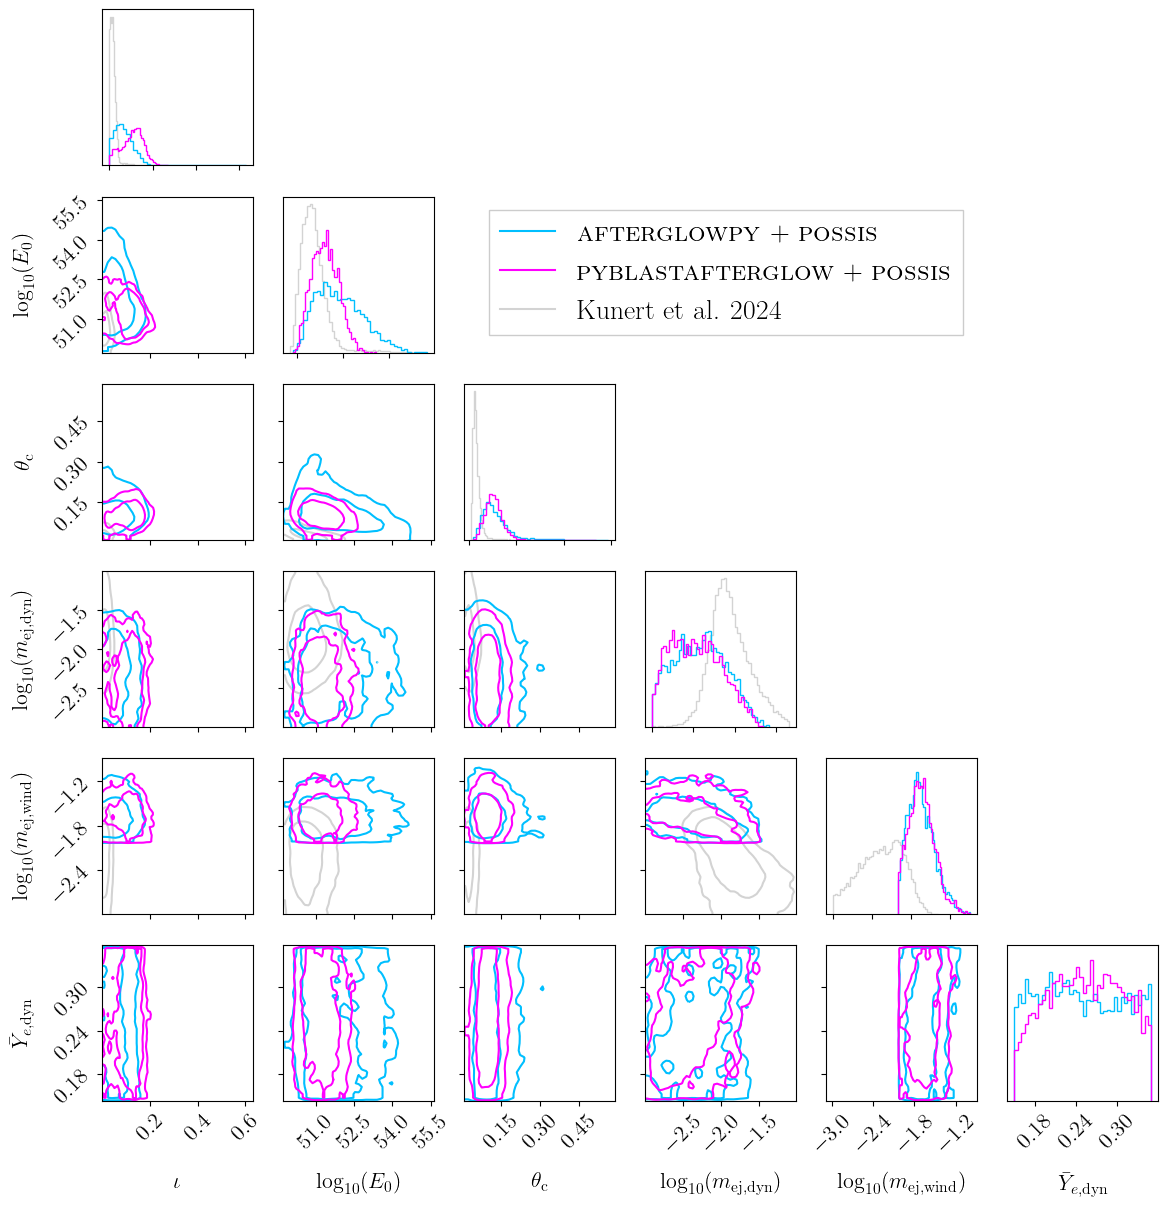

In [20]:
fig, ax = plt.subplots(len(var_names), len(var_names), figsize = (12, 12))


for j in range(len(var_names)-1):
    ax[j,j].hist(posterior_nina[var_names[j]], color="lightgrey", density=True, histtype="step", bins=50)

for j in range(1, len(var_names)-1):
    for k in range(0, j):
        corner.hist2d(x=posterior_nina[var_names[k]].to_numpy(),
                      y=posterior_nina[var_names[j]].to_numpy(),
                      ax=ax[j,k],
                      color="lightgrey",
                      **default_corner_kwargs)

for j in range(5):
    ax[-1, j].set_xlim(ax[-2, j].get_xlim())


corner.corner(posterior_afgpy[var_names],
              fig=fig,
              color = "deepskyblue",
              labelpad = 0.15,
              labels=labels,
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

corner.corner(posterior_pbag[var_names],
              fig=fig,
              color="magenta",
              labelpad=0.15,
              labels=labels,
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

handles = []
for c in ["deepskyblue", "magenta", "lightgrey"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

ax[1, 4].legend(handles=handles, labels=["\\textsc{afterglowpy} + \\textsc{possis}", "\\textsc{pyblastafterglow} + \\textsc{possis}", "Kunert et al. 2024"], fontsize=20, fancybox=False, framealpha=1)
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.96, top=0.99, hspace=0.2, wspace=0.2)


fig.savefig("posterior_GRB211211A.pdf", dpi=250)

In [8]:
low, median, high = corner.quantile(posterior_pbag["Ye_wind"], q=[0.025, 0.5, 0.975])

print([median-low, median, high-median])

[0.06844279170036316, 0.27705705165863037, 0.08877232670783997]


In [ ]:
total_mass = 10**(posterior_pbag["log10_mej_dyn"]) + 10**(posterior_pbag["log10_mej_wind"])

total_mass_nina = 10**(posterior_nina["log10_mej_dyn"]) + 10**(posterior_nina["log10_mej_wind"])

: 

(array([ 7.55585739, 50.32342822, 25.90869063,  6.73038504,  3.14489775,
         1.68639444,  1.10400597,  0.68367342,  0.44565379,  0.2025699 ]),
 array([0.00254256, 0.01276901, 0.02299547, 0.03322193, 0.04344839,
        0.05367485, 0.06390131, 0.07412777, 0.08435423, 0.09458069,
        0.10480715]),
 <BarContainer object of 10 artists>)

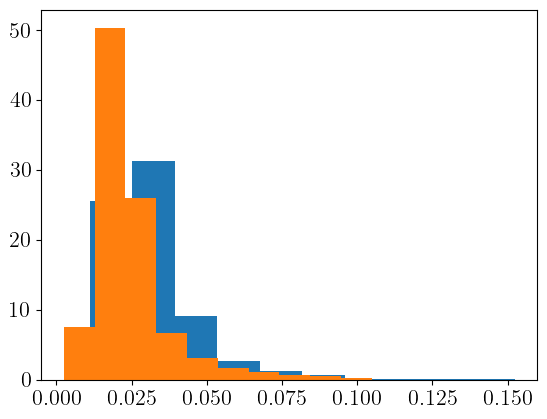

: 

In [ ]:
plt.hist((total_mass), density=True)
plt.hist((total_mass_nina), density=True)

In [ ]:
low, median, high = corner.quantile((total_mass), q=[0.025, 0.5, 0.975])

print(median-low, median, high-median)

0.012394260615110397 0.02825702540576458 0.045326920226216316


: 

low, median, high = corner.quantile((total_mass_nina), q=[0.025, 0.5, 0.975])

print(median-low, median, high-median)

In [ ]:
low, median, high = corner.quantile((total_mass_nina), q=[0.025, 0.5, 0.975])

print(median-low, median, high-median)

0.011822077160038148 0.02128179670806414 0.04256703991388633


: 

# Lightcurves

In [4]:
from fiesta.inference.lightcurve_model import AfterglowFlux, BullaFlux, CombinedSurrogate
from fiesta.utils import load_event_data
from fiesta.inference.likelihood import EMLikelihood

data = load_event_data("../../data/GRB211211A.dat")
trigger_time = 59559.54791666667

model_afgpy = AfterglowFlux(name="afgpy_gaussian_CVAE",
                      filters = data.keys())

model_pbag = AfterglowFlux(name="pbag_gaussian_CVAE",
                           filters=data.keys())

model2 = BullaFlux(name="Bu2025_MLP",
                   filters = data.keys())

model_afgpy = CombinedSurrogate(models=[model_afgpy, model2],
                          sample_times=np.geomspace(0.2, 150, 200))

model_pbag = CombinedSurrogate(models=[model_pbag, model2],
                               sample_times=np.geomspace(0.2, 150, 200))

11:23 fiesta INFO    : Loading surrogate afgpy_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
11:23 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
11:23 fiesta INFO    : 	 log10_E0: (47, 57)
11:23 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
11:23 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
11:23 fiesta INFO    : 	 log10_n0: (-6, 2)
11:23 fiesta INFO    : 	 p: (2.01, 3)
11:23 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
11:23 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
11:23 fiesta INFO    : Surrogate afgpy_gaussian_CVAE is loading with the following filters: ['2massh', '2massj', '2massks', 'X-ray-1keV', 'bessellb', 'besselli', 'bessellr', 'bessellux', 'bessellv', 'ps1::g', 'ps1::i', 'ps1::r', 'ps1::z', 'radio-6GHz', 'uvot::b', 'uvot::u', 'uvot::uvm2', 'uvot::uvw1', 'uvot::uvw2', 'uvot::v', 'uvot::white'].
11:23 fiesta INFO    : Loaded for surrogate afgpy_gaussian_CVAE from /nfs/aya/work/hkoehn/fiesta/fiesta/src/fiesta/surrogate

In [5]:
likelihood_afgpy = EMLikelihood(model_afgpy,
                          data,
                          data.keys(),
                          tmin=0.2,
                          tmax=150.,
                          trigger_time=trigger_time,
                          detection_limit = None,
                          fixed_params={"luminosity_distance": 358.47968, "redshift": 0.0763})

lc_plotter_afgpy = LightcurvePlotter(posterior_afgpy,
                                     likelihood_afgpy,
                                     systematics_file="./systematics_file.yaml")


likelihood_pbag = EMLikelihood(model_pbag,
                          data,
                          data.keys(),
                          tmin=0.2,
                          tmax=150.,
                          trigger_time=trigger_time,
                          detection_limit = None,
                          fixed_params={"luminosity_distance": 358.47968, "redshift": 0.0763})

lc_plotter_pbag = LightcurvePlotter(posterior_pbag,
                                     likelihood_pbag,
                                     systematics_file="./systematics_file.yaml")

11:23 fiesta INFO    : Loading and preprocessing observations in likelihood . . .
11:23 fiesta INFO    : No detection limit is given. Putting it to infinity.
11:23 fiesta INFO    : Loading and preprocessing observations in likelihood . . . DONE
11:23 fiesta INFO    : Loading and preprocessing observations in likelihood . . .
11:23 fiesta INFO    : No detection limit is given. Putting it to infinity.
11:23 fiesta INFO    : Loading and preprocessing observations in likelihood . . . DONE


12:12 fiesta WARNING : Filters {'X-ray-1keV', 'radio-6GHz'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:12 fiesta WARNING : Filters {'X-ray-1keV', 'radio-6GHz'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:12 fiesta WARNING : Filters {'X-ray-1keV', 'radio-6GHz'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:12 fiesta WARNING : Filters {'X-ray-1keV', 'radio-6GHz'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:12 fiesta WARNING : Filters {'X-ray-1keV', 'radio-6GHz'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:12 fiesta WARNING : Filters {'X-ray-1keV', 'radio-6GHz'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:12 fiesta WARNING : Filte

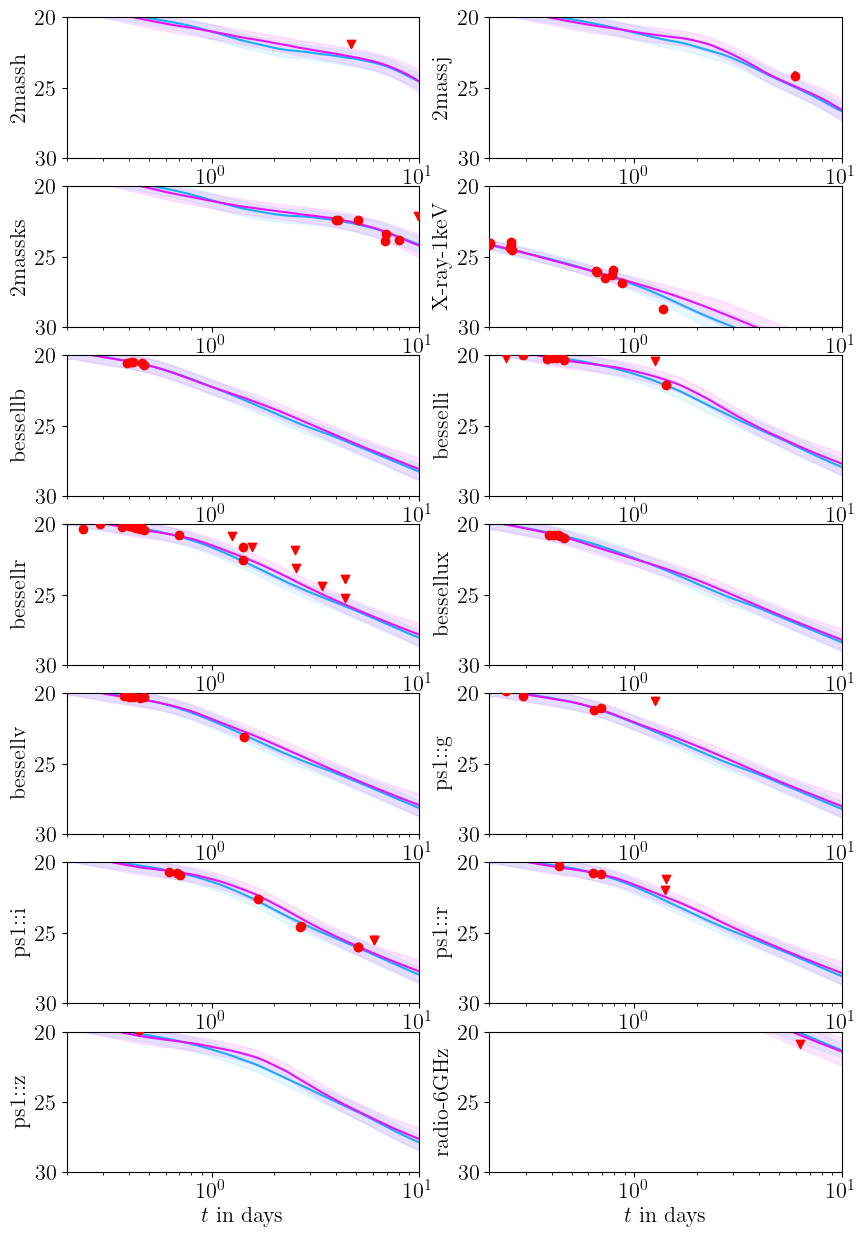

In [11]:
fig, ax = plt.subplots(7, 2, figsize=(10, 15))

for cax, filt in zip(ax.flatten(), data.keys()):
    lc_plotter_afgpy.plot_data(cax, filt, color="red")

    lc_plotter_afgpy.plot_best_fit_lc(cax, filt, color="deepskyblue")
    lc_plotter_pbag.plot_best_fit_lc(cax, filt, color="magenta")
    #lc_plotter.plot_sample_lc(cax, filt)
    lc_plotter_afgpy.plot_sys_uncertainty_band(cax, filt, systematics_file="./systematics_file.yaml", color="deepskyblue")
    lc_plotter_pbag.plot_sys_uncertainty_band(cax, filt, systematics_file="./systematics_file.yaml", color="magenta")
    
    cax.invert_yaxis()
    cax.set_xscale("log")
    cax.set_xlim((0.2, 10))
    cax.set_ylim((30, 20))
    cax.set_xlabel("$t$ in days")
    cax.set_ylabel(filt)

fig.show()